In [12]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [13]:
# File paths
base_folder = r'F:\AlterG\Control\Data'
normative_traces_folder = r'F:\AlterG\NormativeTraces'
save_folder = r'F:\AlterG\IndividualKinematics'

In [14]:
# Step 1: Load Participant Data
def load_participant_data(participant_number):
    participant_folder = os.path.join(base_folder, f"{participant_number:02d}")
    kinematics_path = os.path.join(participant_folder, 'Kinematics', 'concatenated_strides.pkl')
    devices_data_path = os.path.join(participant_folder, 'Gait', 'DevicesData.mat')
    
    if os.path.exists(kinematics_path):
        with open(kinematics_path, 'rb') as f:
            participant_data = pickle.load(f)
            return participant_data
    elif os.path.exists(devices_data_path):
        try:
            mat_data = loadmat(devices_data_path)
            print("Successfully loaded data using `loadmat`.")
            return mat_data
        except NotImplementedError:
            print(f"Error: The file '{devices_data_path}' may be saved in a newer HDF5-compatible format.")
        except Exception as e:
            print(f"Failed to load '{devices_data_path}': {e}")
            return None
    else:
        print(f"No data found for Participant {participant_number}")
        return None

In [58]:
# Step 2: Load and Process Each Participant
def process_participant(participant_number, normative_directory, output_directory):
    participant_data = load_participant_data(participant_number)
    if participant_data is None:
        return

    corrected_data = {}
    for header, strides in participant_data.items():
        if header == 'time':  # Skip 'time' header as it is not used for correction
            continue

        # Debugging: Print header and strides information
        print(f"Processing header: {header}")
        print(f"Strides type: {type(strides)}, Strides keys: {strides.keys() if isinstance(strides, dict) else 'N/A'}")
        print(f"Number of strides_r: {len(strides['strides_r']) if 'strides_r' in strides else 'N/A'}")
        print(f"Number of strides_l: {len(strides['strides_l']) if 'strides_l' in strides else 'N/A'}")

        # Process strides_r and strides_l separately if they exist
        for side in ['strides_r', 'strides_l']:
            if side in strides:
                side_strides = strides[side]
                # Debugging: Print more details on side strides
                print(f"Processing {side}: Number of strides: {len(side_strides)}")
                if len(side_strides) == 0:
                    print(f"No strides available for {side} in header {header}, skipping.")
                    continue

                # Debugging: Print details of the first stride
                first_stride = side_strides[0]
                if isinstance(first_stride, dict) and 'normalized_stride_data' in first_stride:
                    stride_data = first_stride['normalized_stride_data']
                    print(f"First stride type: {type(first_stride)}")
                    print(f"First stride normalized data shape/length: {len(stride_data) if hasattr(stride_data, '__len__') else 'N/A'}")
                    print(f"First stride normalized data contents: {stride_data}")
                    print(f"Stride min: {np.min(stride_data)}, max: {np.max(stride_data)}, mean: {np.mean(stride_data)}")
                else:
                    print(f"Unexpected first stride structure: {first_stride}")
                    continue

                try:
                    normative_trace = load_saved_normative(normative_directory, header)
                except FileNotFoundError as e:
                    # Adjust header format to match normative trace filenames if necessary
                    adjusted_header = f"{header}_normative_median"
                    try:
                        normative_trace = load_saved_normative(normative_directory, adjusted_header)
                    except FileNotFoundError:
                        print(f"Normative trace for header {header} not found, even after adjustment.")
                        continue

                # Use normalized stride data directly, no need for resampling
                corrected_strides = []
                for stride in side_strides:
                    if 'normalized_stride_data' in stride:
                        corrected_stride = correct_stride(stride['normalized_stride_data'], normative_trace)
                        stride['corrected_stride_data'] = corrected_stride  # Add corrected stride to the original structure
                        corrected_strides.append(corrected_stride)

                if header not in corrected_data:
                    corrected_data[header] = {}
                corrected_data[header][side] = side_strides  # Preserve original structure, including corrected strides

                # Plot corrected strides and mean corrected trace
                plt.figure(figsize=(12, 6))
                for stride in corrected_strides:
                    plt.plot(stride, color='g', alpha=0.3)
                mean_corrected_trace = np.mean(corrected_strides, axis=0)
                plt.plot(mean_corrected_trace, color='k', linewidth=2, label='Mean Corrected Trace')
                plt.legend()
                plt.title(f"Corrected Strides and Mean Corrected Trace for Header: {header} ({side})")
                plt.xlabel("Time Points")
                plt.ylabel("Value")
                plt.show()

    # Save corrected data
    save_corrected_data(output_directory, participant_number, corrected_data)




In [53]:
# Step 3: Load Normative Trace
def load_saved_normative(normative_directory, header):
    normative_file = os.path.join(normative_directory, f"{header}.pkl")
    if os.path.exists(normative_file):
        with open(normative_file, 'rb') as f:
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"Normative trace for header {header} not found.")

In [59]:
# Step 4: Correct Individual Strides
def correct_stride(stride, normative_trace):
    # Correlation-based flipping
    correlation = np.corrcoef(stride, normative_trace)[0, 1]
    flipped_correlation = np.corrcoef(-stride, normative_trace)[0, 1]
    if flipped_correlation > correlation:
        stride = -stride

    # Offset correction (demean if necessary)
    stride_mean = np.mean(stride)
    normative_mean = np.mean(normative_trace)
    if abs(stride_mean - normative_mean) > 0.1 * normative_mean:  # threshold at 10%
        stride = stride - stride_mean + normative_mean

    return stride


In [60]:
# Step 5: Visualization
def visualize_strides(original_strides, corrected_strides, participant_id):
    plt.figure(figsize=(12, 8))

    # Original strides
    plt.subplot(2, 1, 1)
    for stride in original_strides:
        plt.plot(stride, alpha=0.5)
    plt.title(f"Participant {participant_id} - Original Strides")
    plt.xlabel("Time Points")
    plt.ylabel("Stride Value")

    # Corrected strides
    plt.subplot(2, 1, 2)
    for stride in corrected_strides:
        plt.plot(stride, alpha=0.5)
    plt.title(f"Participant {participant_id} - Corrected Strides")
    plt.xlabel("Time Points")
    plt.ylabel("Stride Value")

    plt.tight_layout()
    plt.show()


In [67]:
def save_corrected_data(output_directory, participant_id, corrected_data):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    output_file = os.path.join(output_directory, f"{participant_id:02d}_corrected.pkl")
    with open(output_file, 'wb') as f:
        pickle.dump(corrected_data, f)

Processing header: pelvis_tilt
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 3.60957181  2.80703136  2.00479314  1.15563197  0.28657928 -0.49965818
 -1.10503144 -1.47095056 -1.60500144 -1.54892977 -1.38327512 -1.17536667
 -0.96168879 -0.76930197 -0.6194589  -0.51781039 -0.39464822 -0.24826343
 -0.05754344  0.16968203  0.42768005  0.71737824  0.98551774  1.14315829
  1.26666584  1.32435788  1.32178639  1.27530003  1.20384678  1.12553689
  1.0515433   0.98698864  0.91854609  0.81990882  0.67495164  0.47962155
  0.25829472  0.00680192 -0.2651794  -0.5567791  -0.81525896 -1.01924645
 -1.21058231 -1.32707928 -1.34578133 -1.27454692 -1.06000068 -0.72892286
 -0.32579301  0.10987173  0.5785102   1.10936275  1.71482116  2.38656704
  3

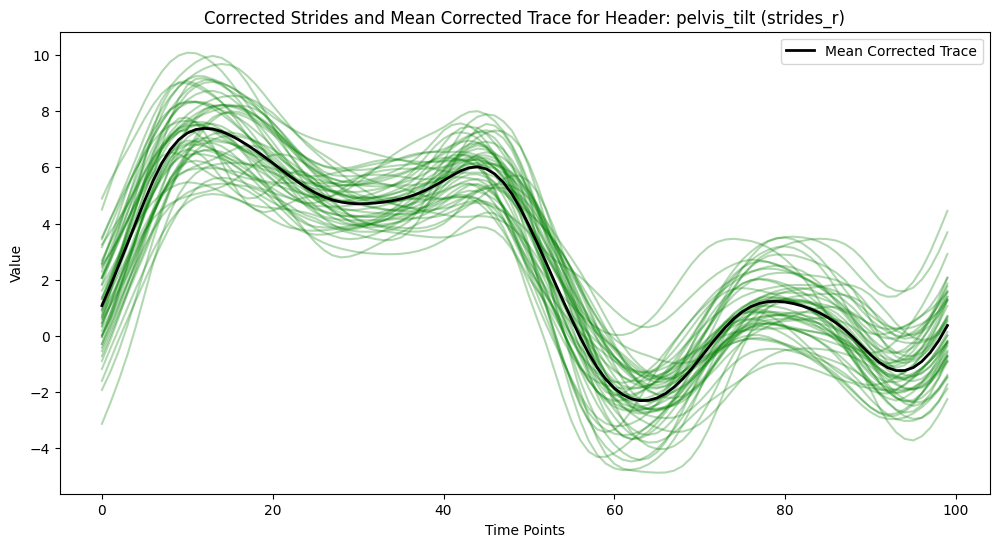

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 1.45829371  2.08227941  2.75695966  3.3506775   3.87661533  4.31395829
  4.6578275   4.929669    5.16593272  5.40303216  5.63592272  5.89136018
  6.12435425  6.30229018  6.38873893  6.37591934  6.24909172  6.00389689
  5.64894959  5.20806357  4.72003417  4.21883655  3.76331575  3.4014553
  3.14432625  2.99526341  2.92713685  2.93462337  2.99525514  3.09818347
  3.24409126  3.41223345  3.59509516  3.78154797  3.97473639  4.17552527
  4.40029398  4.678519    5.00953429  5.38127647  5.74920985  6.05455684
  6.26744571  6.35742316  6.30576018  6.09249641  5.7502767   5.29627522
  4.73131434  4.03529917  3.25243899  2.48046429  1.74527032  0.96012527
  0.11567542 -0.79764363 -1.67537243 -2.40603743 -2.93158316 -3.25304865
 -3.41290651 -3.47458579 -3.4922862  -3.49037766 -3.4613137  -3.38715221
 -3.33555072 -3.20263324 -3.024745

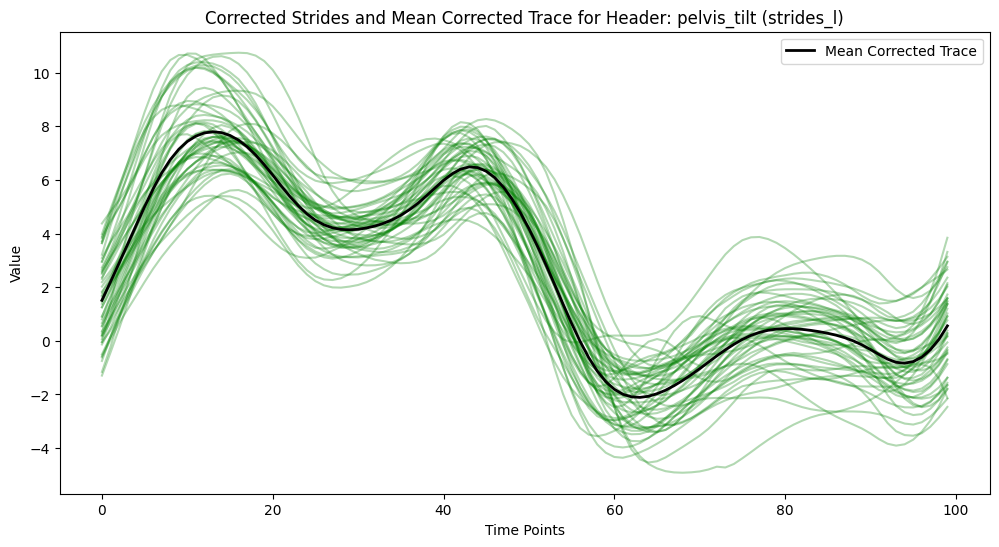

Processing header: pelvis_list
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [3.90895207 4.01590349 4.25563676 4.6060127  5.03595131 5.46660441
 5.86240682 6.2084594  6.49784168 6.73027161 6.90264761 7.01633015
 7.07927037 7.11372438 7.14909923 7.1953167  7.27453336 7.36443044
 7.43349032 7.44879928 7.3935428  7.26492026 7.08812632 6.8778052
 6.66428383 6.46349869 6.29003372 6.14163008 5.99728663 5.82873283
 5.61451641 5.34572615 5.03426464 4.7059573  4.37901907 4.06005537
 3.73960855 3.41580967 3.0810365  2.73300504 2.37215013 2.00655288
 1.65647095 1.33937009 1.05761174 0.84459472 0.67521116 0.53141911
 0.39433641 0.27323547 0.19295894 0.16969296 0.20573124 0.28624234
 0.39500872 0.52325737 0.64011184 0.74159546 0.81305738 0.

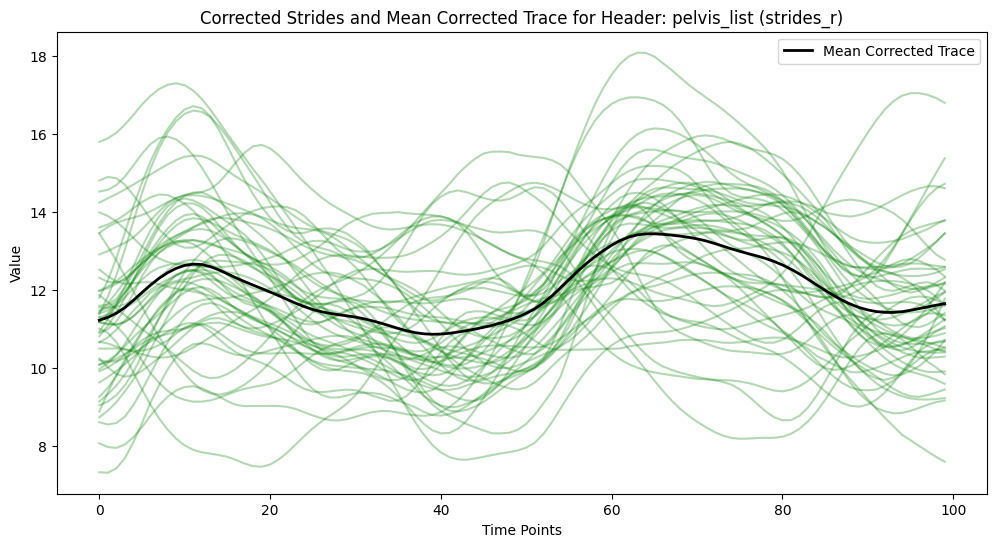

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [0.17796384 0.24550618 0.33827717 0.45770326 0.5753225  0.68162501
 0.76766947 0.82433154 0.84704819 0.83612811 0.80779354 0.80279193
 0.80206089 0.80699643 0.83415516 0.86442084 0.88464422 0.90470762
 0.91944356 0.91930878 0.92108217 0.9127963  0.90830658 0.90420208
 0.90587295 0.92676049 0.96330663 1.01821937 1.07722463 1.12428923
 1.14809088 1.1321827  1.07490757 0.99471519 0.87069275 0.76842408
 0.67857063 0.62299865 0.60115575 0.6253787  0.68149821 0.74043022
 0.81424517 0.91527569 1.05794664 1.25047667 1.47353756 1.70429533
 1.92031631 2.08214253 2.19415661 2.28118012 2.37310547 2.50881638
 2.68254538 2.88948903 3.10375893 3.29371074 3.439279   3.52293762
 3.52870406 3.45223405 3.30343884 3.10077076 2.8669538  2.63216316
 2.42516193 2.23209602 2.05174938 1.86924638 1.67227136 1.45561527
 1.22177622 0.98946847 0.7839444

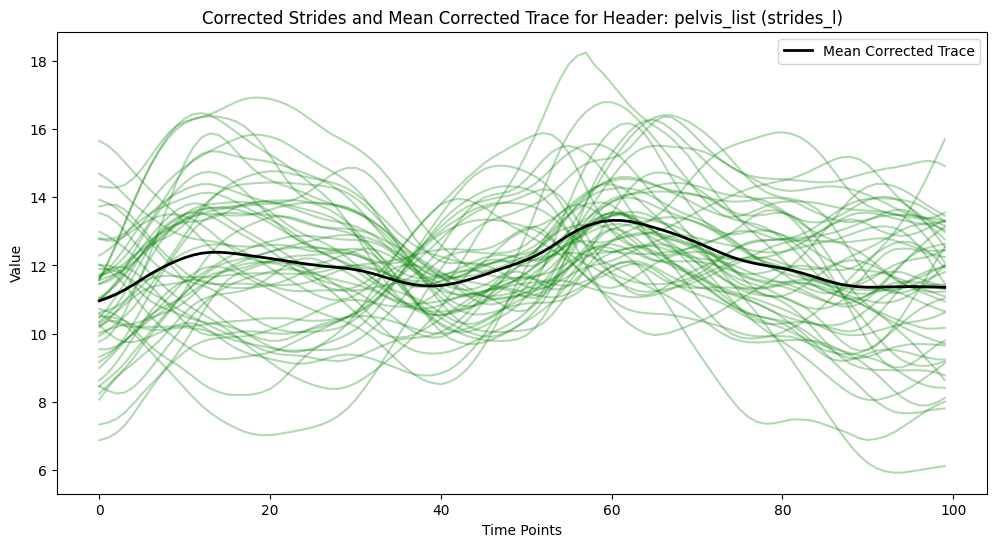

Processing header: pelvis_rotation
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 86.42955515  86.31571814  86.39758681  86.68981635  87.1568066
  87.66095954  88.04177888  88.17662621  88.0245555   87.64789551
  87.17169955  86.73980484  86.47177631  86.43035659  86.6207058
  87.00483878  87.52855444  88.11946208  88.700764    89.23740944
  89.70227448  90.10359294  90.46573608  90.82456635  91.20458144
  91.60698246  92.03230949  92.47230682  92.92352899  93.38745037
  93.8634956   94.34830898  94.82516257  95.2692419   95.66958815
  96.02938411  96.37098553  96.69881197  97.02106566  97.34115245
  97.65432356  97.97260555  98.26608596  98.54771038  98.82245159
  99.07812141  99.33859242  99.60515027  99.86063341 100.0746406

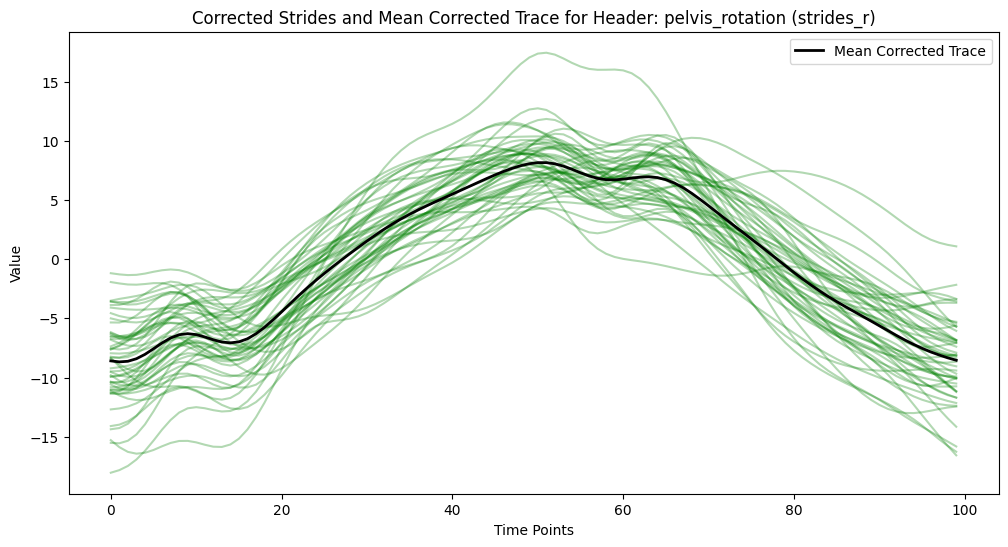

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [100.29008119 100.274554   100.31207697 100.44288575 100.70894933
 101.09491026 101.55050068 102.00765538 102.40216885 102.69290596
 102.85115777 102.87861824 102.8116673  102.6982189  102.54885286
 102.38621014 102.21052189 102.00038394 101.7460166  101.44921496
 101.10600368 100.73364836 100.33213238  99.9114593   99.47100404
  99.0080363   98.51622149  97.99808933  97.46094176  96.92169297
  96.40403872  95.9247796   95.48774654  95.08626823  94.68461244
  94.25653957  93.78191873  93.26206453  92.69991885  92.10106772
  91.46642234  90.79831906  90.1144662   89.43977316  88.80582881
  88.25088859  87.78626566  87.40919289  87.10814125  86.87303146
  86.71358201  86.66284093  86.75380447  87.00237951  87.42296326
  87.95676301  88.47049026  88.82147122  88.92469055  88.76899005
  88.41113957  87.95761637  87.5327912   87.

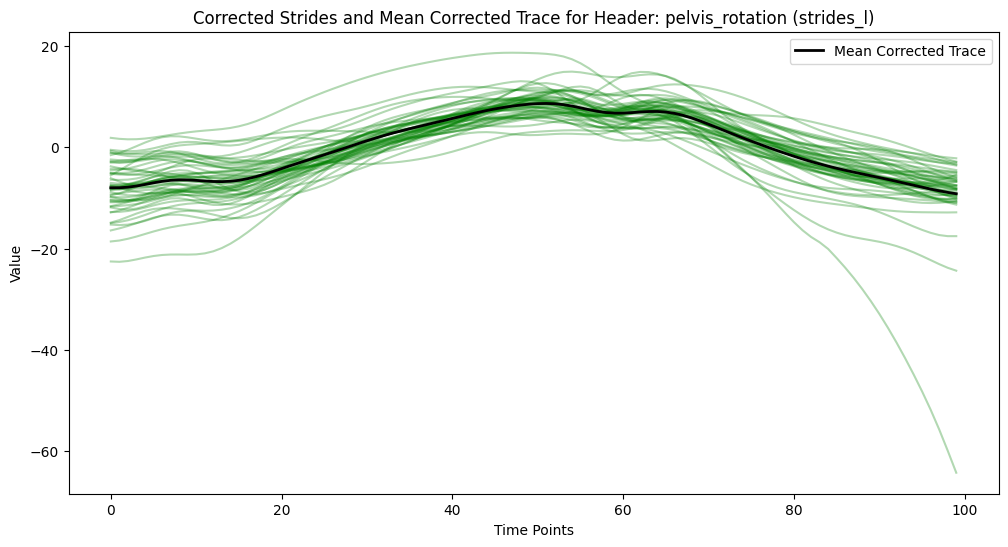

Processing header: pelvis_tx
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [0.20905485 0.20987349 0.2108659  0.21209363 0.21359154 0.21527007
 0.21697216 0.21853856 0.21987454 0.22099984 0.22201874 0.22306614
 0.2242533  0.22562343 0.22714399 0.22874327 0.23036269 0.2319343
 0.23340498 0.23476288 0.2359825  0.23705442 0.23796206 0.2387588
 0.23945171 0.24006883 0.24062176 0.24111343 0.24154971 0.24193833
 0.24228356 0.24258595 0.24283308 0.24300496 0.24309568 0.2431169
 0.24310216 0.243067   0.2430297  0.24299723 0.2429702  0.24294554
 0.24287145 0.24273057 0.24251031 0.2421872  0.24176891 0.24125538
 0.24064399 0.23993324 0.239137   0.23829275 0.23745875 0.23670543
 0.23608645 0.23561684 0.23528894 0.23503987 0.23480394 0.2345

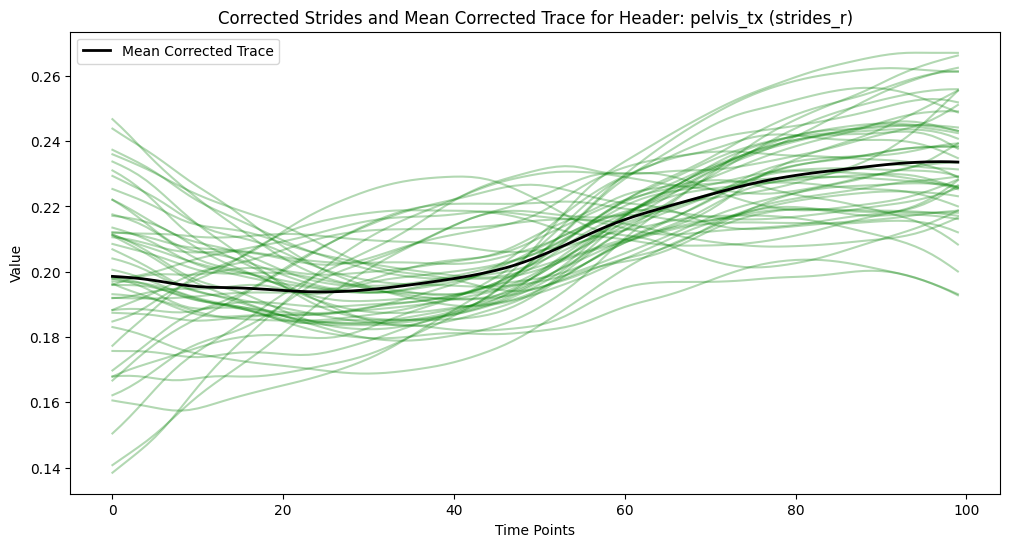

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [0.23777346 0.23700795 0.23635941 0.23584338 0.23546647 0.23518992
 0.23495838 0.23471652 0.23442721 0.23408559 0.23370032 0.23329158
 0.23293194 0.23265186 0.23244974 0.23233152 0.23228274 0.23227418
 0.23229187 0.23233458 0.23239755 0.23249807 0.23263301 0.23281749
 0.23305247 0.23334242 0.2336882  0.23408816 0.23453931 0.23503756
 0.23557991 0.23616498 0.23678822 0.23745155 0.23812304 0.23879282
 0.23943531 0.24004463 0.24061553 0.2411532  0.24166657 0.24217577
 0.24272769 0.2433783  0.24418416 0.24520936 0.24645078 0.24790155
 0.24954275 0.25134435 0.25327782 0.2553135  0.25740994 0.25952975
 0.26168461 0.26386729 0.26602633 0.26806615 0.26988695 0.27143581
 0.27272222 0.27381672 0.2748246  0.27585118 0.27697539 0.27823929
 0.27965775 0.28123089 0.28290059 0.28461887 0.28633721 0.28801267
 0.28961917 0.29114755 0.2926017

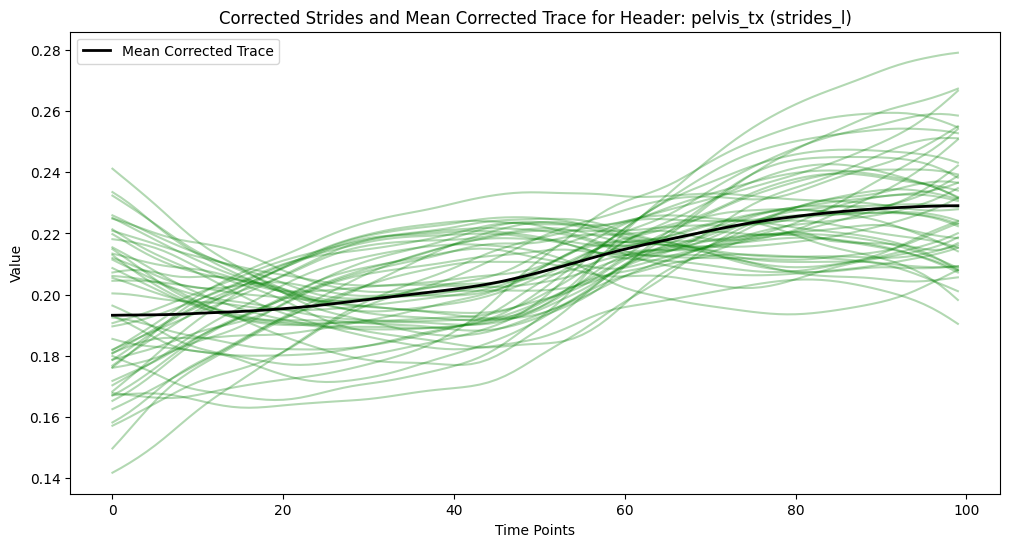

Processing header: pelvis_ty
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [0.7147234  0.71439521 0.71446347 0.71492378 0.71569209 0.71658877
 0.71749071 0.7183365  0.71913046 0.71993573 0.7208361  0.7218792
 0.72309826 0.72451755 0.72611788 0.72787441 0.72973856 0.73164135
 0.73349697 0.73522088 0.73675544 0.73805613 0.73914159 0.73998443
 0.7406281  0.74109706 0.74143013 0.74165005 0.7417493  0.74170055
 0.74147515 0.74104909 0.74043207 0.73965269 0.73870743 0.73758026
 0.7362319  0.7346427  0.73280089 0.73070781 0.72840759 0.72593675
 0.72336607 0.72078711 0.71824501 0.71587049 0.71366447 0.71163211
 0.70974348 0.70799586 0.70644441 0.70516245 0.70421185 0.70363887
 0.70347955 0.70375518 0.70445878 0.70556443 0.70701162 0.70

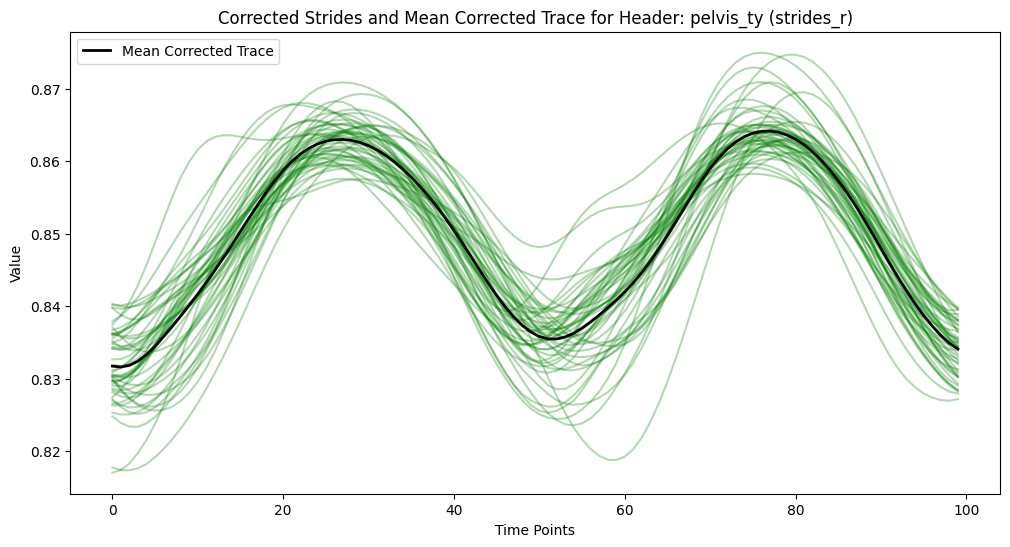

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [0.70449455 0.7038069  0.70348688 0.70356037 0.70402784 0.70487563
 0.70606442 0.70754612 0.7092556  0.71112966 0.71320886 0.71546767
 0.71797263 0.72066823 0.72356112 0.72659369 0.72970877 0.73287261
 0.73602137 0.73907304 0.74197413 0.74464184 0.74702919 0.74905084
 0.75073238 0.752094   0.75314926 0.75391562 0.75440089 0.75460274
 0.75451461 0.75412817 0.75343766 0.75246033 0.7511629  0.74961505
 0.74781401 0.74577925 0.74354253 0.74116681 0.7386996  0.73616536
 0.73360192 0.73104142 0.72851762 0.72605938 0.72367511 0.72138802
 0.71925116 0.71727538 0.71549254 0.71389718 0.71249167 0.7113815
 0.7106391  0.71028665 0.71033988 0.71074153 0.71150303 0.71265534
 0.71422832 0.71624357 0.71868766 0.72150449 0.72461815 0.72795297
 0.73144069 0.73492113 0.73829648 0.7414569  0.74430893 0.74678189
 0.74883951 0.75049307 0.75178205

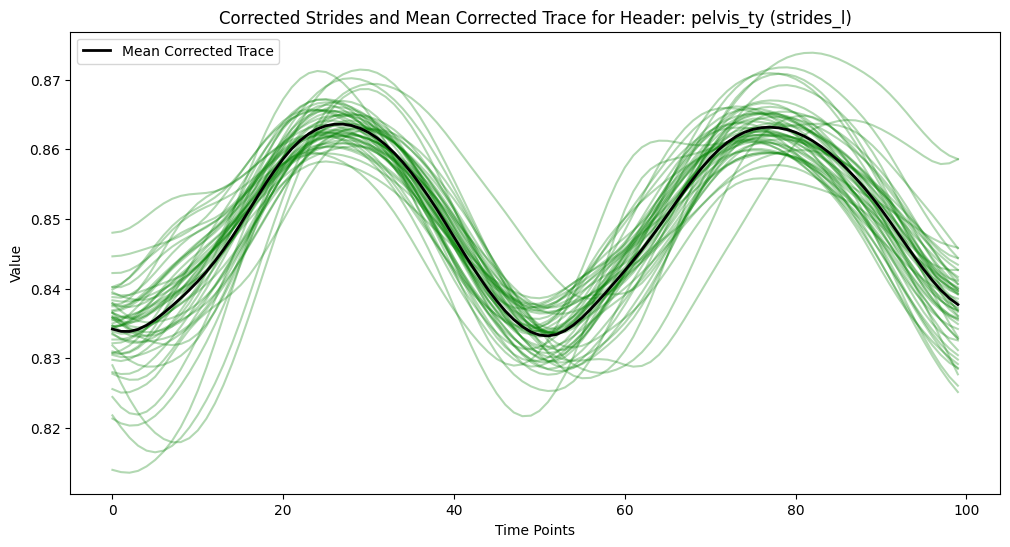

Processing header: pelvis_tz
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [3.58209285 3.56832138 3.55464984 3.54109053 3.52766077 3.51439327
 3.50133101 3.48851226 3.47595305 3.46364558 3.45156528 3.43968589
 3.42797397 3.41639283 3.4049065  3.39346836 3.38206673 3.37068754
 3.3593464  3.34806734 3.33686955 3.3257776  3.31478686 3.30394486
 3.29323322 3.28263095 3.27207955 3.26153328 3.25097225 3.24039594
 3.22980591 3.21919002 3.2085086  3.19770429 3.18673584 3.17559463
 3.1643007  3.15286509 3.14129755 3.12961375 3.11778357 3.10581429
 3.09369423 3.0813772  3.06882575 3.05597348 3.04284432 3.02947652
 3.01588797 3.00209468 2.98812576 2.97402307 2.95983571 2.94561649
 2.93142995 2.91735205 2.90343845 2.8897611  2.8763778  2.8

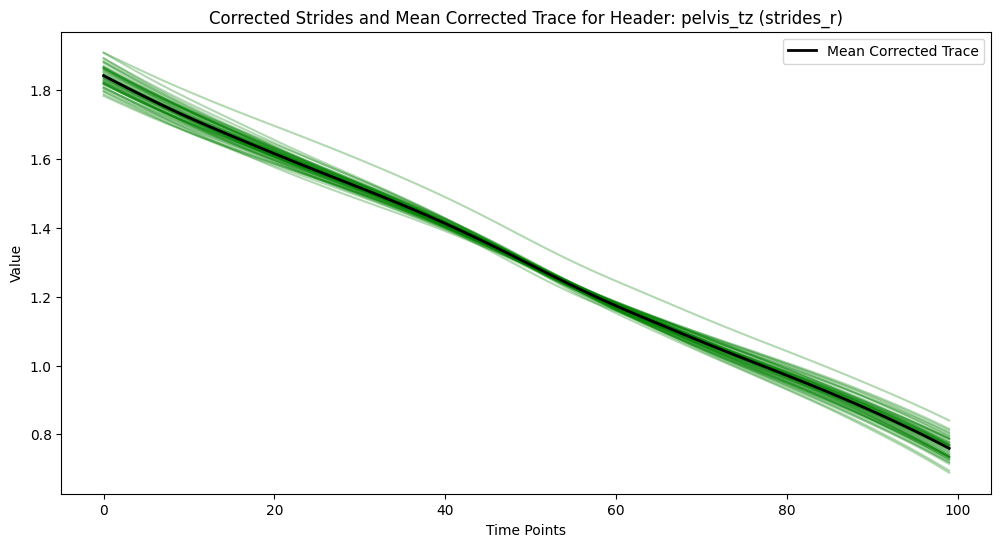

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [2.96543341 2.95181739 2.93820631 2.92467285 2.91126439 2.89803933
 2.88505385 2.87234568 2.85993715 2.84783307 2.83599339 2.82438766
 2.81296472 2.80165521 2.79040156 2.77917055 2.76794827 2.75673891
 2.74556983 2.73448039 2.72350475 2.71267495 2.70199923 2.69148208
 2.68107513 2.67073066 2.66041412 2.65009474 2.63975581 2.62938012
 2.61894817 2.60845193 2.59788737 2.58725912 2.57652877 2.56571398
 2.55475187 2.54358819 2.53218389 2.5205537  2.50872469 2.4967118
 2.48453001 2.47216507 2.45957517 2.44667391 2.43344911 2.41990365
 2.40608261 2.39212787 2.37816876 2.36429555 2.35056256 2.33698804
 2.32359261 2.31038106 2.29738794 2.28461895 2.27208476 2.2597726
 2.24765537 2.23569403 2.22384543 2.21206825 2.2003246  2.18858317
 2.17682019 2.16504073 2.15325461 2.1414923  2.12979807 2.11821457
 2.10676928 2.09546004 2.08426976 

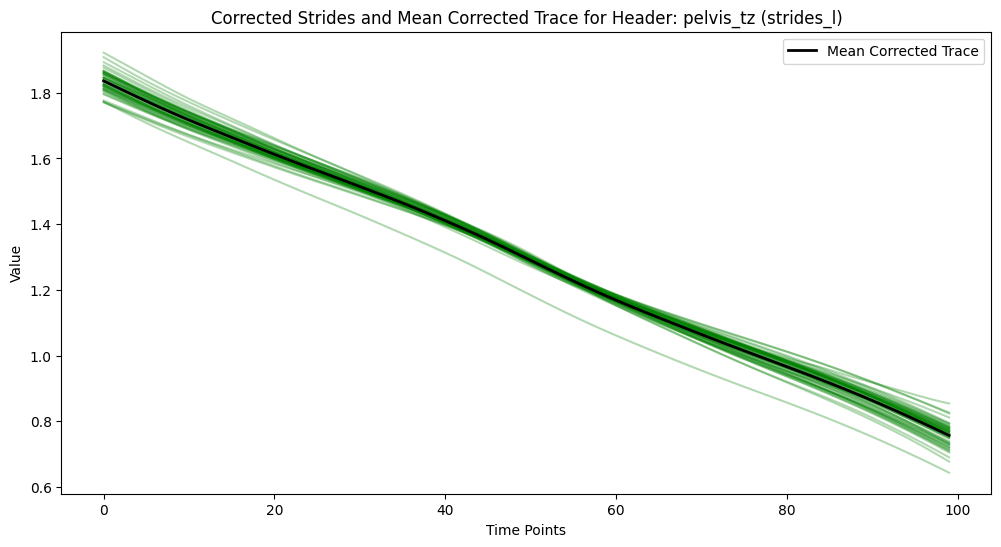

Processing header: lumbar_extension
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [25.58409846 25.56740342 25.73187252 26.05058543 26.49814854 26.96038513
 27.37628655 27.71077006 27.95170548 28.10763126 28.19092505 28.23239939
 28.2509435  28.26885161 28.30903044 28.33970521 28.42536956 28.5141313
 28.56875238 28.55740429 28.46789883 28.3164173  28.084428   27.87662205
 27.67131273 27.51030055 27.38903538 27.29933134 27.2179446  27.11412559
 26.96468156 26.75334349 26.48665206 26.18855836 25.87194477 25.5461855
 25.20369423 24.84434841 24.46275236 24.06908295 23.63585785 23.1851085
 22.75378934 22.36145986 21.98191735 21.65412921 21.34216496 21.0449571
 20.7329724  20.41784482 20.13763605 19.912795   19.74440214 19.60757201
 1

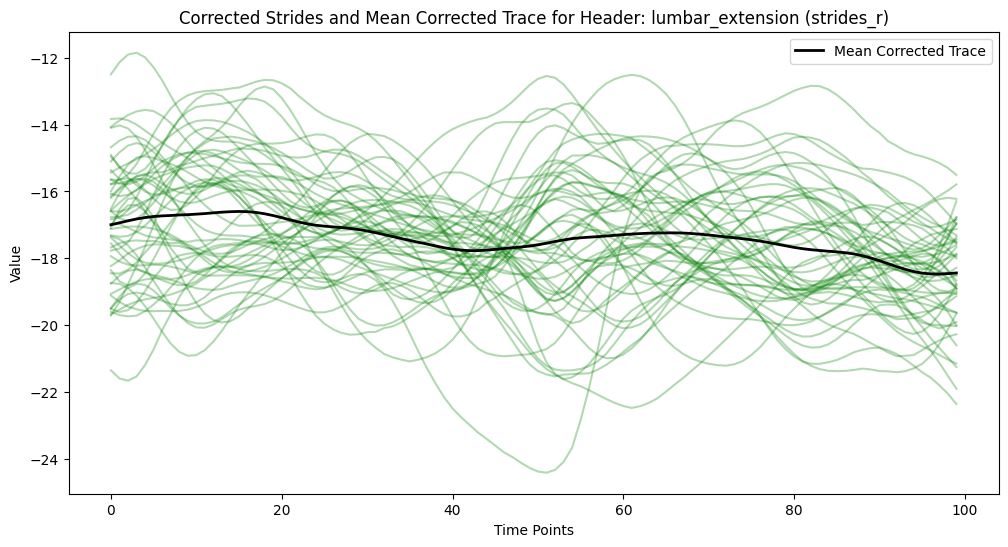

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [19.79867472 19.66666034 19.53730771 19.4476895  19.34296175 19.22236093
 19.09750887 18.97693079 18.87107383 18.78888488 18.7466975  18.80931698
 18.90798029 19.04281407 19.2351811  19.43712373 19.62662578 19.83178529
 20.04893941 20.26008424 20.4940134  20.72435891 20.9670557  21.20817674
 21.45209575 21.70784321 21.97337059 22.25098202 22.52427527 22.77389931
 22.98450617 23.1365366  23.2306088  23.30594825 23.29809683 23.34015998
 23.38117937 23.43900284 23.50303087 23.61835303 23.77599583 23.92286996
 24.08433782 24.26483205 24.46035615 24.65833945 24.83065059 24.9584863
 25.02319296 25.02157802 24.99433226 24.99158812 25.05877952 25.24023831
 25.53012095 25.91306783 26.33552288 26.71722181 27.00205138 27.1508707
 27.14380002 26.98687715 26.71238933 26.36187716 25.97033009 25.5767219
 25.21704425 24.87994656 24.55809632

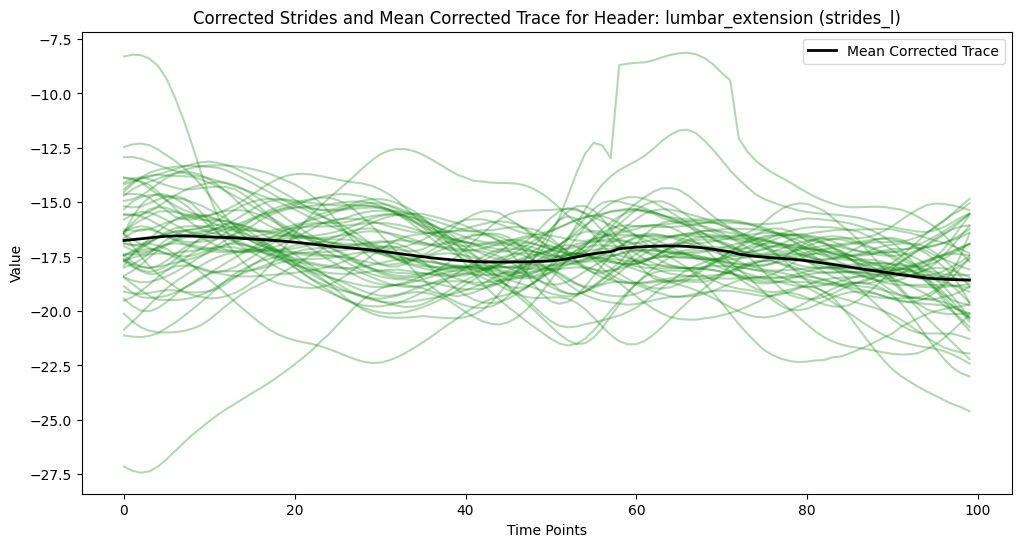

Processing header: lumbar_bending
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 0.94592972 -0.08723224 -1.06024406 -1.99975215 -2.85253107 -3.52950393
 -3.97558688 -4.18183601 -4.19055832 -4.0376422  -3.77238017 -3.4200838
 -2.97930179 -2.45984672 -1.90646849 -1.36953433 -0.76731543 -0.1405939
  0.50865952  1.1625675   1.8051311   2.46096161  2.99176051  3.42474759
  3.78975432  4.08018768  4.29601972  4.45503156  4.57960403  4.6892951
  4.79512324  4.90271289  4.9910868   5.02024716  4.968757    4.83640399
  4.67144693  4.46778152  4.24040678  3.98492413  3.77523662  3.64429578
  3.51249271  3.44221846  3.48200884  3.61213268  3.90249628  4.31670352
  4.79440954  5.28572112  5.79363908  6.3602813   7.01251146  7.75733792
  8

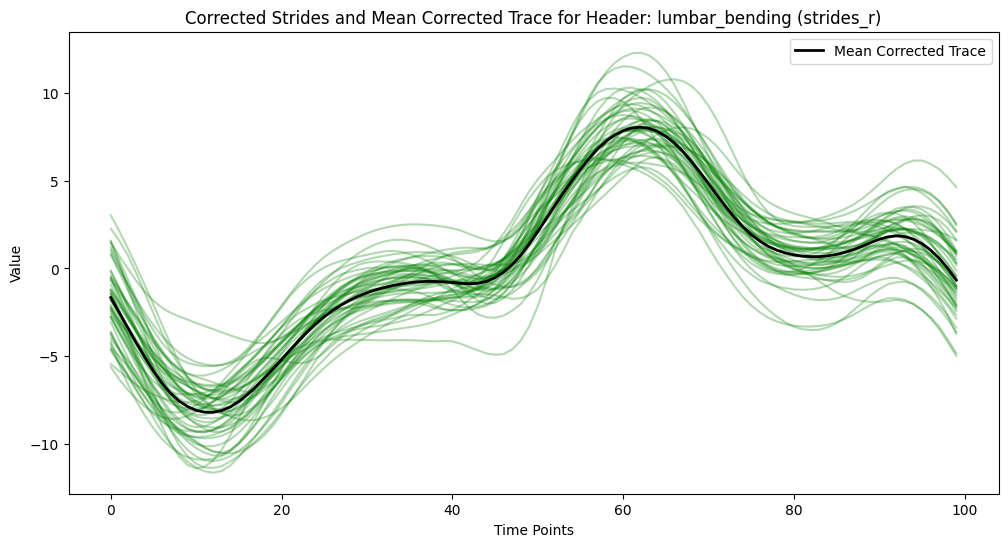

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 6.73250268  7.41360512  8.17938497  8.85839494  9.47718913  9.99353731
 10.37924338 10.64153089 10.80935757 10.92283633 10.98806119 11.03395495
 11.04483812 10.99309481 10.8339896  10.56826154 10.17770746  9.65092053
  8.99567756  8.24157098  7.43495073  6.61747737  5.858987    5.21726132
  4.70348725  4.32546625  4.04768463  3.86671738  3.75265239  3.6927172
  3.69310373  3.72979885  3.79628788  3.88255197  3.97542324  4.0840973
  4.20168746  4.35690885  4.53908546  4.74263183  4.91587928  4.98408124
  4.9289354   4.72923973  4.38158639  3.8772811   3.2596667   2.55008385
  1.7373595   0.79343528 -0.22986711 -1.20817232 -2.11206531 -3.05528268
 -4.00332228 -4.977649   -5.86728667 -6.59124868 -7.12015444 -7.46756332
 -7.66976501 -7.76468366 -7.77330731 -7.69051746 -7.48728226 -7.14101382
 -6.77359934 -6.25287163 -5.6657416

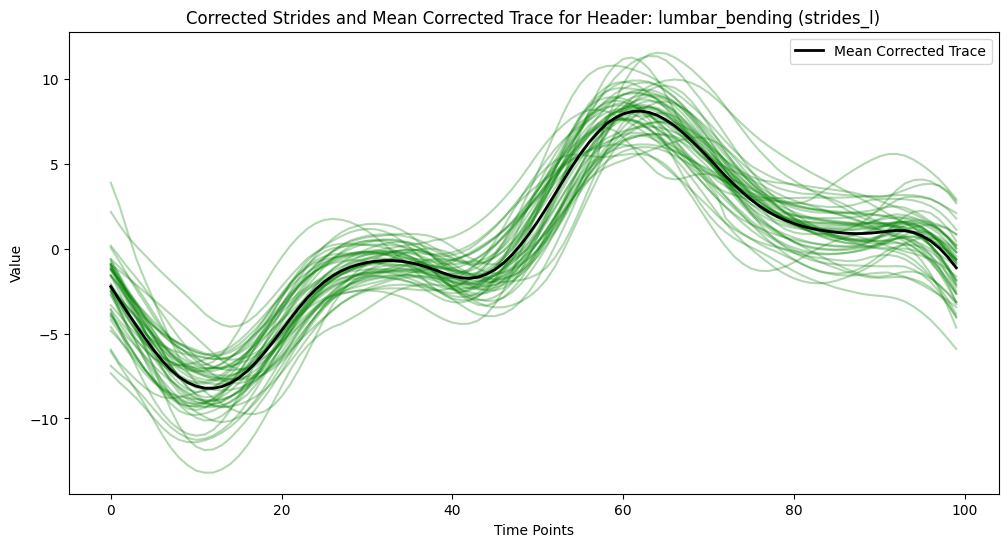

Processing header: lumbar_rotation
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 50
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [13.09414152 12.93927531 12.67762743 12.28973081 11.79016463 11.28237231
 10.88726022 10.70635509 10.77685782 11.02819504 11.3094697  11.50712492
 11.53729393 11.34462021 10.89743722 10.15580366  9.30229908  8.36774486
  7.5381347   6.71260336  5.97639644  5.40643156  4.84630955  4.14050198
  3.51112689  2.86778995  2.21466659  1.56517378  0.92552649  0.302325
 -0.29969554 -0.85613707 -1.39135698 -1.94585583 -2.47324287 -2.96779475
 -3.44314326 -3.91320905 -4.37839845 -4.84452723 -5.28598468 -5.69916857
 -6.10190247 -6.47699435 -6.7584801  -7.08218833 -7.32269515 -7.52713245
 -7.6920202  -7.80703545 -7.87113893 -7.87153735 -7.82268284 -7.77353663
 

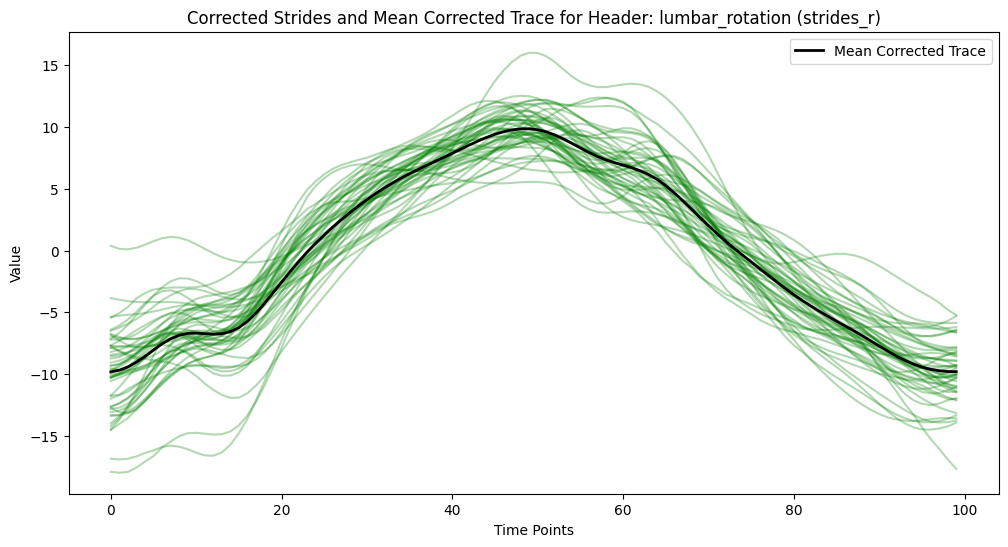

Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [-7.84853514e+00 -7.78565116e+00 -7.76461538e+00 -7.80894239e+00
 -7.93451943e+00 -8.10949833e+00 -8.27123231e+00 -8.32629359e+00
 -8.21193460e+00 -7.92680512e+00 -7.39692192e+00 -6.58141852e+00
 -5.59647581e+00 -4.57957101e+00 -3.52206199e+00 -2.49474867e+00
 -1.53222045e+00 -5.90755290e-01  3.36897474e-01  1.22337264e+00
  2.09982533e+00  2.97385686e+00  3.83583372e+00  4.70714064e+00
  5.60109265e+00  6.45403061e+00  7.37709363e+00  8.27079550e+00
  9.14725510e+00  9.99818935e+00  1.07556145e+01  1.14491431e+01
  1.20371609e+01  1.25473623e+01  1.30423381e+01  1.35303829e+01
  1.40435690e+01  1.45937636e+01  1.51761172e+01  1.57817048e+01
  1.63908520e+01  1.69739105e+01  1.75031357e+01  1.79511654e+01
  1.82916808e+01  1.84863093e+01  1.85376856e+01  1.84776561e+01
  1.83449137e+01  1.81067048e+01  1.77799521e+01  1.7407

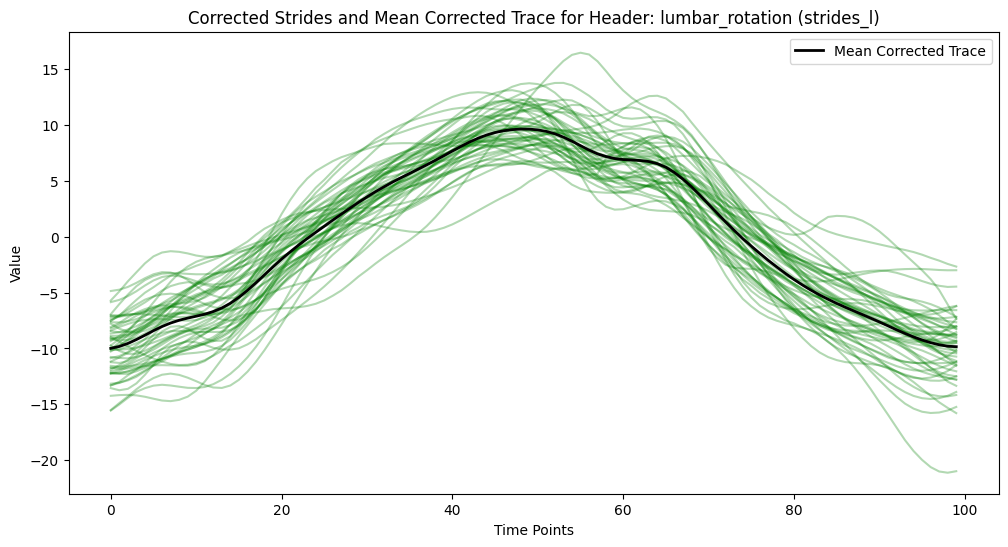

Processing header: hip_flexion_r
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 0
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 19.92386252  21.10492537  22.08514245  22.54449818  22.50750025
  22.16434724  21.64019343  21.01561924  20.32257353  19.56915969
  18.73865067  17.8496553   16.90974387  15.88556259  14.76431103
  13.52367872  12.18895758  10.78264922   9.36853373   7.99597341
   6.70110722   5.51693839   4.40652156   3.34023166   2.32518515
   1.31906387   0.29133356  -0.76327081  -1.81819359  -2.83001958
  -3.76415433  -4.59805488  -5.3702544   -6.15520914  -6.97882602
  -7.8507495   -8.72435721  -9.59784624 -10.45058132 -11.24960594
 -12.03939529 -12.79358688 -13.50935477 -14.24582533 -14.94957626
 -15.78618833 -16.60704604 -17.38424112 -18.09678488 -18.73941299

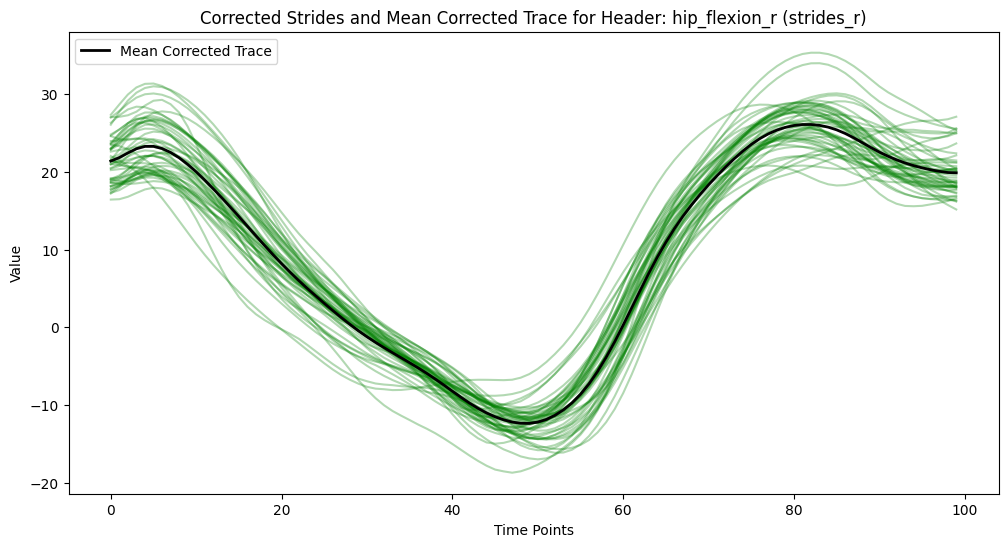

Processing strides_l: Number of strides: 0
No strides available for strides_l in header hip_flexion_r, skipping.
Processing header: hip_adduction_r
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 0
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 5.70572320e-01  4.01391535e-03 -6.07049623e-01 -1.41549500e+00
 -2.40737373e+00 -3.41303285e+00 -4.25491667e+00 -4.81123768e+00
 -5.05125956e+00 -5.04146740e+00 -4.91437792e+00 -4.79010490e+00
 -4.73974336e+00 -4.79306266e+00 -4.95713280e+00 -5.20521108e+00
 -5.42035472e+00 -5.57260396e+00 -5.63270771e+00 -5.59076515e+00
 -5.46101993e+00 -5.25813241e+00 -5.03490102e+00 -4.88970470e+00
 -4.76563164e+00 -4.70027097e+00 -4.68694098e+00 -4.70615085e+00
 -4.73505705e+00 -4.75248321e+00 -4.74606103e+00 -4.71278701e+00
 -4.66942302e+00 -4.6448

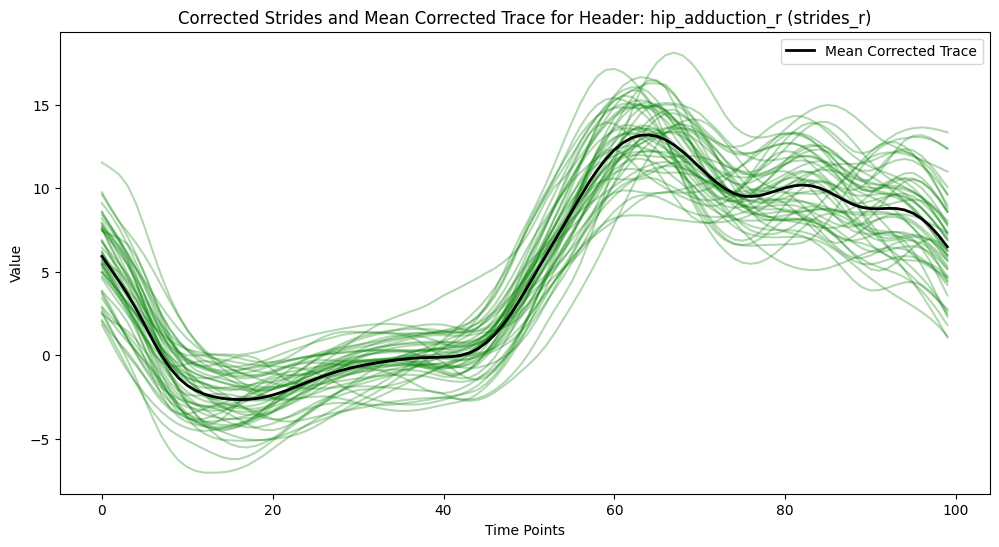

Processing strides_l: Number of strides: 0
No strides available for strides_l in header hip_adduction_r, skipping.
Processing header: hip_rotation_r
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 0
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 9.20518799  9.84027776 10.15581803 10.2016923  10.03167491  9.75504784
  9.50081925  9.37729757  9.48254351  9.75666147 10.09289079 10.35289377
 10.4190463  10.25905643  9.86801623  9.30101541  8.62802061  7.93261547
  7.24901998  6.67227791  6.22076961  5.86090391  5.62907598  5.53730458
  5.44293696  5.34331997  5.2283555   5.09748799  4.95097805  4.78526323
  4.59774689  4.37759568  4.13533573  3.89844256  3.67873783  3.47406093
  3.19525803  2.86326068  2.45992691  1.95718388  1.42885391  0.79985881
  0.18603862 -0.44247967 -1.0555

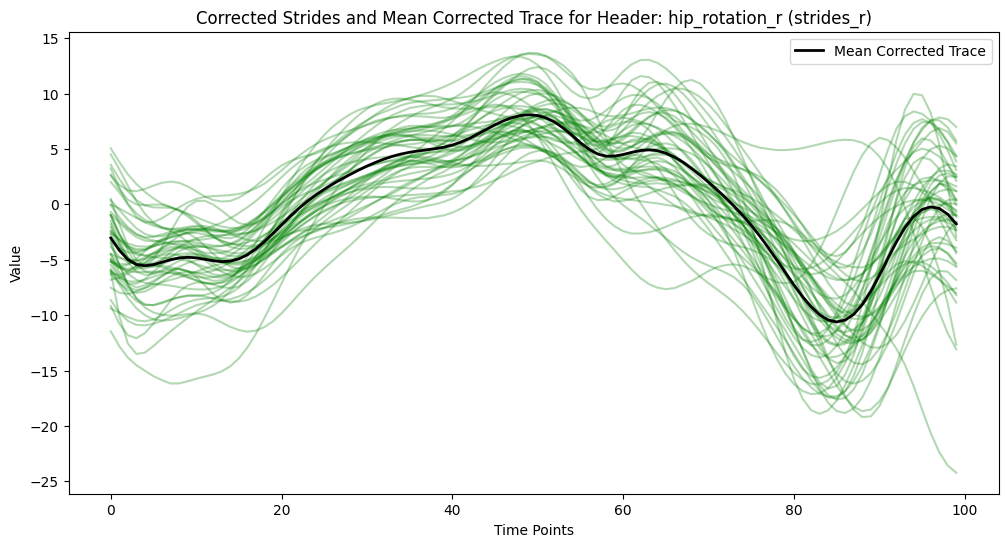

Processing strides_l: Number of strides: 0
No strides available for strides_l in header hip_rotation_r, skipping.
Processing header: knee_angle_r
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 0
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 6.72694584 10.92150405 15.068147   18.45432423 21.04608591 23.06861546
 24.71564246 26.11905237 27.3209732  28.32171234 29.06537999 29.56922308
 29.84958164 29.88624745 29.71697674 29.33238141 28.84502563 28.25273665
 27.60232932 26.90884304 26.19472325 25.5100294  24.83857912 24.14927024
 23.52360751 22.92067796 22.32262583 21.72219248 21.12999231 20.57141001
 20.06975498 19.65319861 19.28312019 18.88578312 18.45929323 18.00181322
 17.57656226 17.18375684 16.84545431 16.61788813 16.40822146 16.27330362
 16.25730318 16.26897832 16.4018588

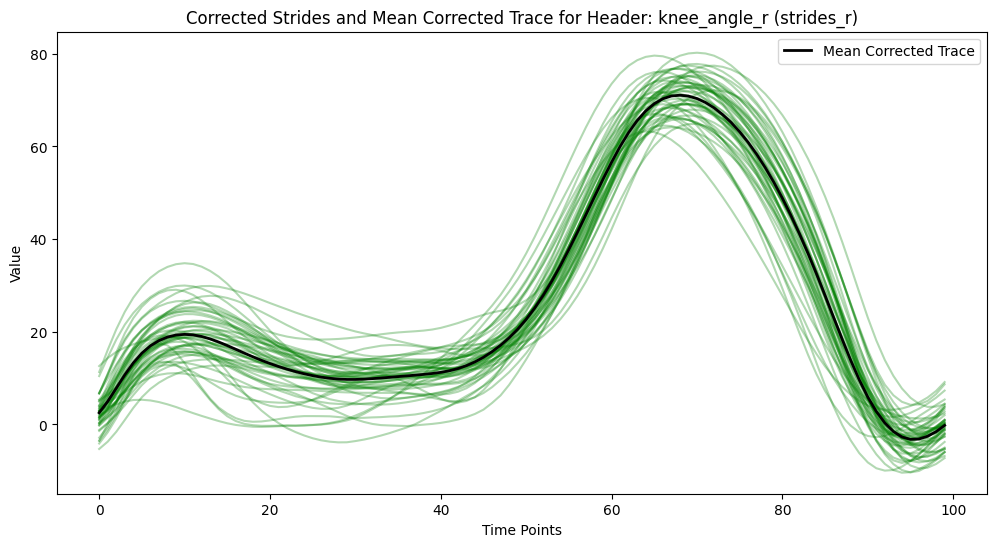

Processing strides_l: Number of strides: 0
No strides available for strides_l in header knee_angle_r, skipping.
Processing header: ankle_angle_r
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 0
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 8.72530069  8.5898553   9.1438389  10.01645431 11.04688717 12.24892342
 13.57577473 14.96967435 16.32813523 17.605933   18.77146226 19.80737921
 20.73524923 21.54933682 22.2624802  22.94108276 23.48550666 23.92423388
 24.322352   24.63188538 24.88207953 25.07132117 25.21667401 25.26488357
 25.27888177 25.25594792 25.21312186 25.15998139 25.09703661 25.02324789
 24.93688781 24.83496035 24.71102468 24.56062453 24.3896405  24.20432771
 24.00573887 23.80851525 23.61951205 23.43248461 23.28503794 23.08478073
 22.96117297 22.74157044 22.46073483

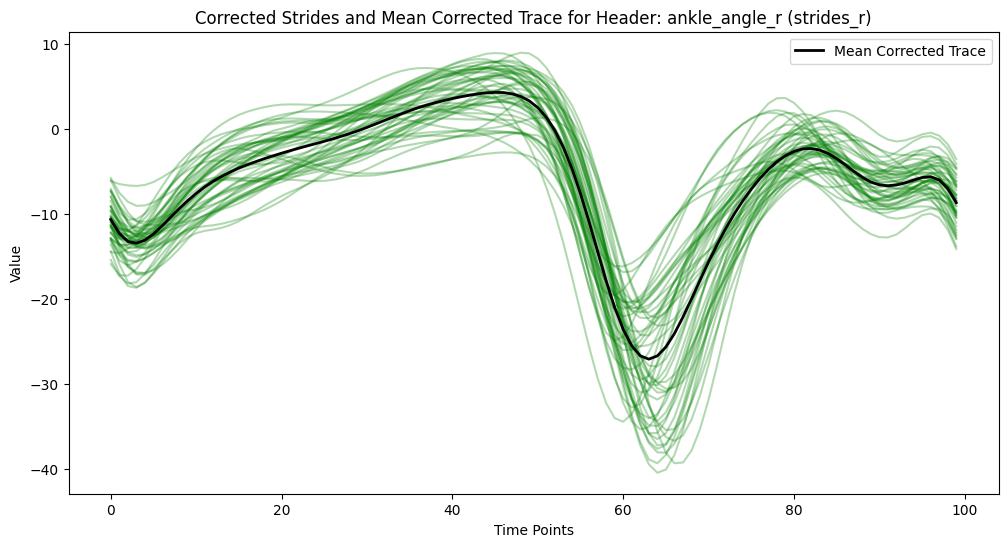

Processing strides_l: Number of strides: 0
No strides available for strides_l in header ankle_angle_r, skipping.
Processing header: subtalar_angle_r
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 0
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 6.60000000e-07  6.60000000e-07  7.58888889e-07  8.12424242e-07
  9.23737374e-07  1.01727273e-06  1.04000000e-06  1.08525253e-06
  1.13383838e-06  1.12272727e-06  1.06040404e-06  1.02444444e-06
  1.03393939e-06  1.05030303e-06  1.04949495e-06  9.95151515e-07
  9.83838384e-07  9.98585859e-07  9.90000000e-07  9.86767677e-07
  9.10808081e-07  8.63030303e-07  8.77777778e-07  7.96161616e-07
  7.48484848e-07  7.10505051e-07  6.51919192e-07  6.04545455e-07
  5.66565657e-07  5.39292929e-07  5.05757576e-07  4.75656566e-07
  4.43131313e-07  3.966

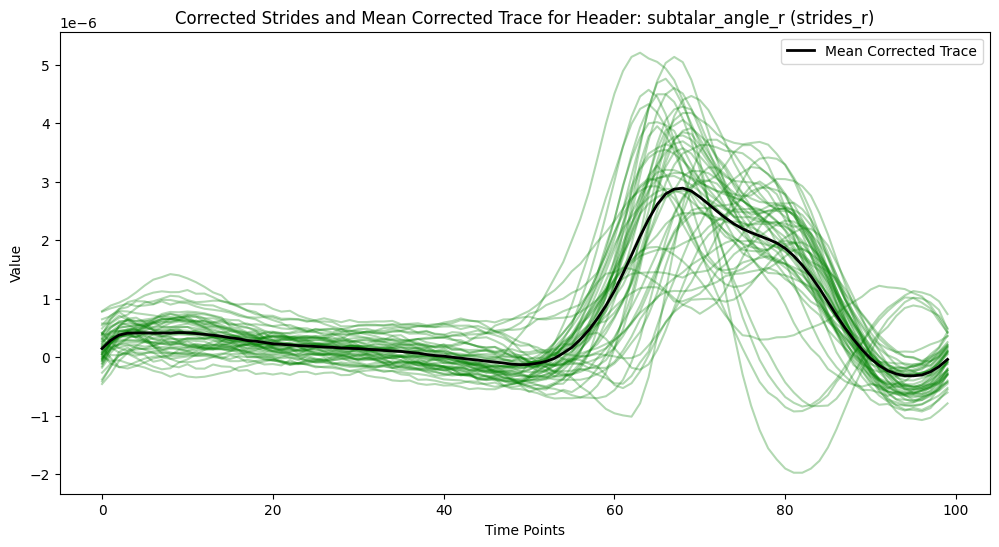

Processing strides_l: Number of strides: 0
No strides available for strides_l in header subtalar_angle_r, skipping.
Processing header: mtp_angle_r
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 49
Number of strides_l: 0
Processing strides_r: Number of strides: 49
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Stride min: 0.0, max: 0.0, mean: 0.0


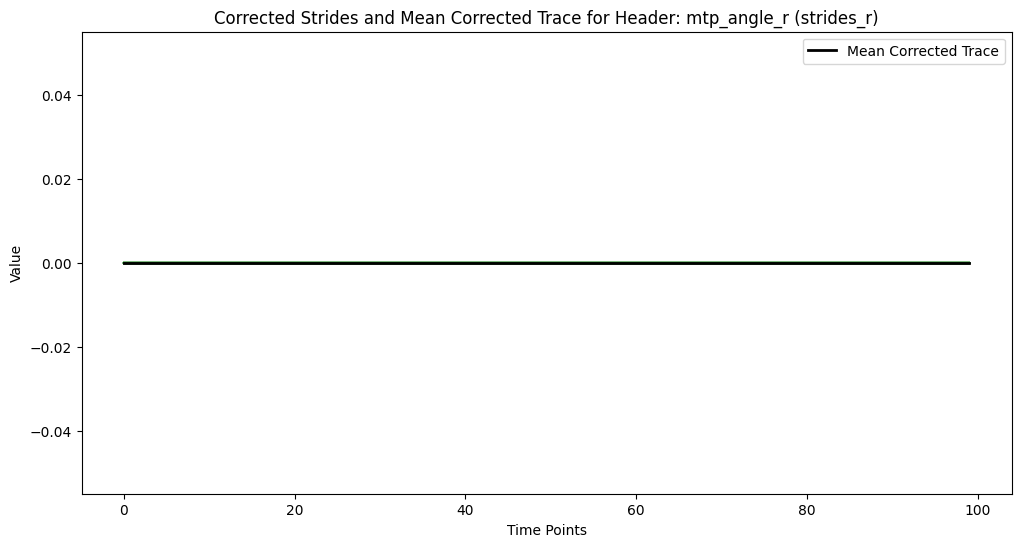

Processing strides_l: Number of strides: 0
No strides available for strides_l in header mtp_angle_r, skipping.
Processing header: hip_flexion_l
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 0
Number of strides_l: 50
Processing strides_r: Number of strides: 0
No strides available for strides_r in header hip_flexion_l, skipping.
Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 32.33885549  32.86196465  33.03606123  32.90079886  32.46740353
  31.76962296  30.86056763  29.79124242  28.6164477   27.38444972
  26.0668122   24.66247736  23.13505584  21.51800949  19.78209675
  17.95834307  16.07784743  14.13367091  12.15556953  10.19227813
   8.24919901   6.38811907   4.61639295   2.98117484   1.47334721
   0.05714886  -1.24960458  -2.4960477   -3.66807304  -4.77367675
  -5.84023448  -6.81798059  -7.7072949 

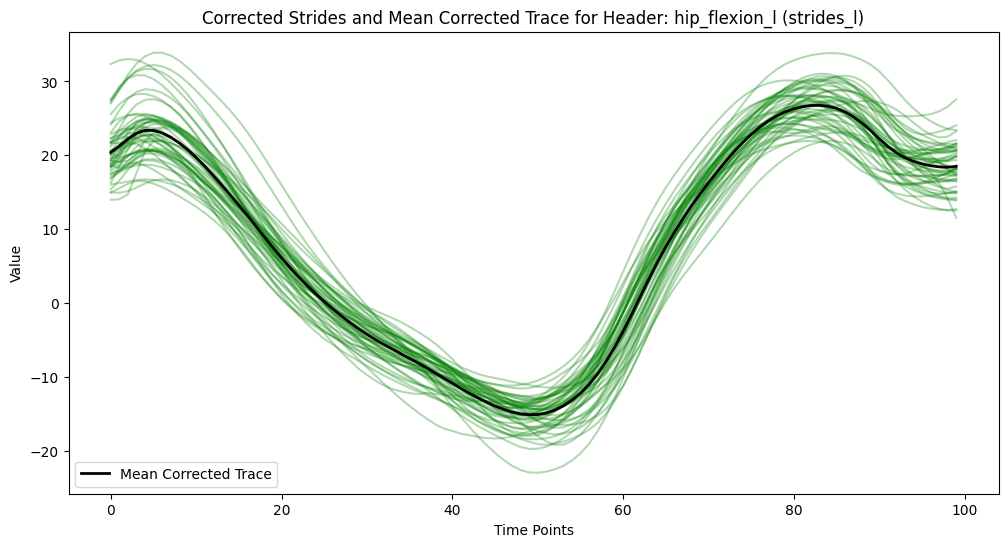

Processing header: hip_adduction_l
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 0
Number of strides_l: 50
Processing strides_r: Number of strides: 0
No strides available for strides_r in header hip_adduction_l, skipping.
Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [ 3.17825653  2.67653767  2.0458296   1.45033634  0.92800789  0.50732441
  0.17238771 -0.13761934 -0.48347596 -0.90064472 -1.42711923 -2.06867876
 -2.77409981 -3.47207311 -4.11237518 -4.67140145 -5.12251065 -5.44641406
 -5.64006397 -5.71674589 -5.70034192 -5.62075129 -5.53296958 -5.47823104
 -5.47279652 -5.52834643 -5.61044596 -5.72808935 -5.85890505 -6.00059634
 -6.16872959 -6.33432134 -6.49083254 -6.63816898 -6.77479697 -6.88126677
 -6.97651454 -7.09477018 -7.23750518 -7.38452575 -7.47966496 -7.45782893
 -7.29027195 -6.95512186 -6.451

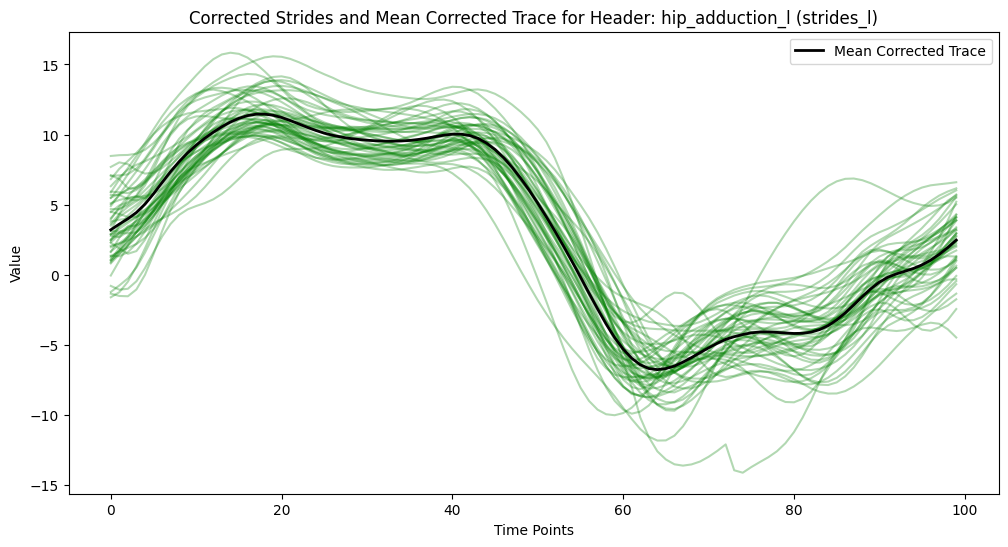

Processing header: hip_rotation_l
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 0
Number of strides_l: 50
Processing strides_r: Number of strides: 0
No strides available for strides_r in header hip_rotation_l, skipping.
Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [18.76932268 18.58987785 18.55279917 18.61394454 18.88123752 19.34271707
 19.92881337 20.54655554 21.13188349 21.66491204 22.04604484 22.30242598
 22.41568142 22.40982427 22.31232892 22.13300641 21.86922949 21.56673386
 21.23307628 20.86333805 20.51176283 20.13584611 19.75808276 19.35344691
 18.92064401 18.4621907  17.96646814 17.44947979 16.91525946 16.38402527
 15.89532184 15.47549738 15.14799975 14.84422265 14.60867313 14.31272497
 13.95087135 13.47140079 12.84403984 12.03708789 11.05371413  9.93517543
  8.7266647   7.50144129  6.33295

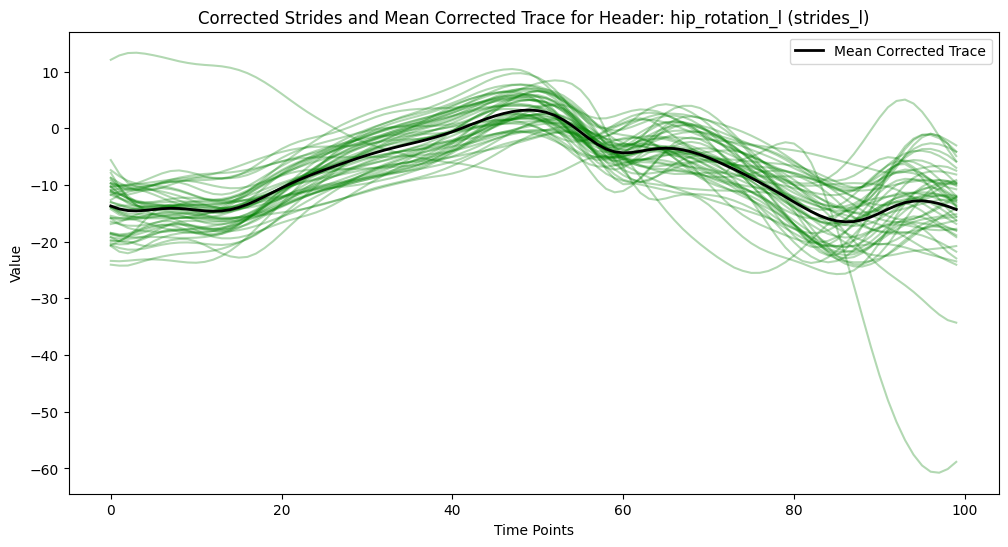

Processing header: knee_angle_l
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 0
Number of strides_l: 50
Processing strides_r: Number of strides: 0
No strides available for strides_r in header knee_angle_l, skipping.
Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [27.49921284 30.36295164 32.62011672 34.4095762  35.72155215 36.60227191
 37.10703284 37.26654669 37.1264716  36.74422958 36.08131719 35.21411924
 34.06894586 32.75085561 31.27290511 29.66416024 27.96478298 26.18731182
 24.36669891 22.55346909 20.77351    19.09782486 17.54941658 16.19636263
 15.04127982 14.05025042 13.26722392 12.61355543 12.10081623 11.69219703
 11.31898171 11.05128737 10.88769783 10.81771106 10.70228431 10.77636726
 10.92050969 11.11068712 11.29850772 11.55069998 11.92157032 12.41811041
 13.10633576 14.0120532  15.10238404 

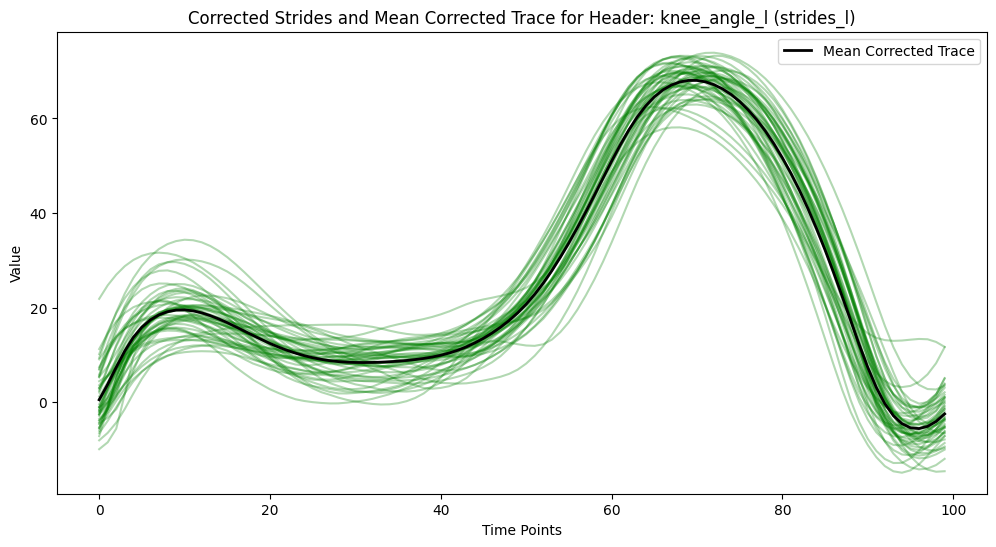

Processing header: ankle_angle_l
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 0
Number of strides_l: 50
Processing strides_r: Number of strides: 0
No strides available for strides_r in header ankle_angle_l, skipping.
Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [  8.12078983   9.32971788  10.62706878  12.08718453  13.51784619
  14.85288329  16.06300549  17.10991852  17.98678709  18.72316891
  19.30229194  19.66061022  19.89206556  20.0187209   19.99615531
  19.87406033  19.6846149   19.37378547  18.95865406  18.4917181
  17.93128185  17.34663602  16.71876578  16.08165407  15.46062088
  14.83790691  14.29673554  13.78497388  13.36604483  13.03770397
  12.74354736  12.57332904  12.49548841  12.43786631  12.36865132
  12.32710184  12.31271141  12.32470915  12.34083013  12.37719577
  12.43433556  12.4

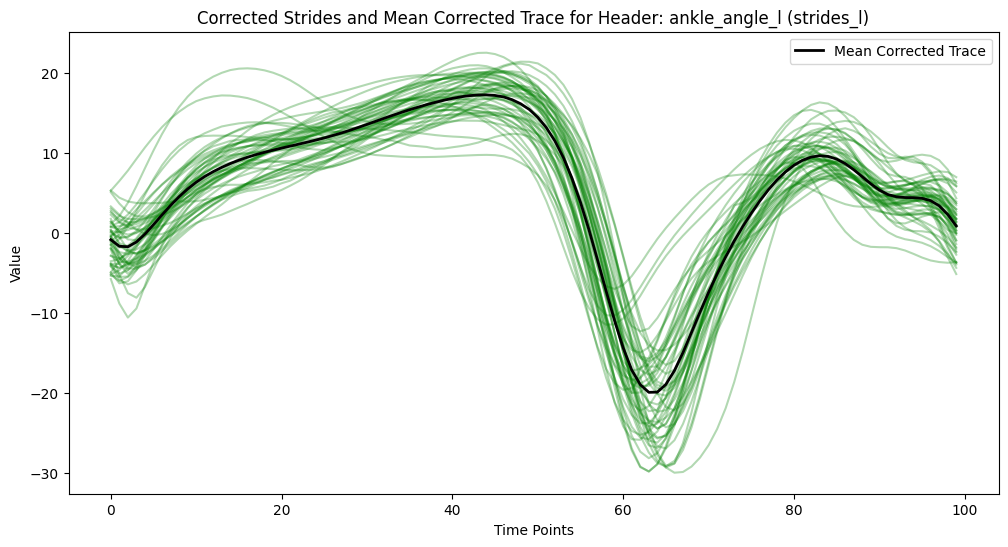

Processing header: subtalar_angle_l
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 0
Number of strides_l: 50
Processing strides_r: Number of strides: 0
No strides available for strides_r in header subtalar_angle_l, skipping.
Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [1.35000000e-06 1.49545455e-06 1.54272727e-06 1.65181818e-06
 1.67727273e-06 1.71363636e-06 1.68636364e-06 1.62818182e-06
 1.61909091e-06 1.49363636e-06 1.41818182e-06 1.40000000e-06
 1.32727273e-06 1.24636364e-06 1.19363636e-06 1.13545455e-06
 1.09909091e-06 1.08090909e-06 1.04818182e-06 9.99090909e-07
 9.55454545e-07 8.86363636e-07 8.50000000e-07 8.31818182e-07
 8.21818182e-07 8.05454545e-07 7.80909091e-07 7.64545455e-07
 7.37272727e-07 7.10000000e-07 7.04545455e-07 6.77272727e-07
 6.23636364e-07 6.60000000e-07 6.69090909e-07 7.0272

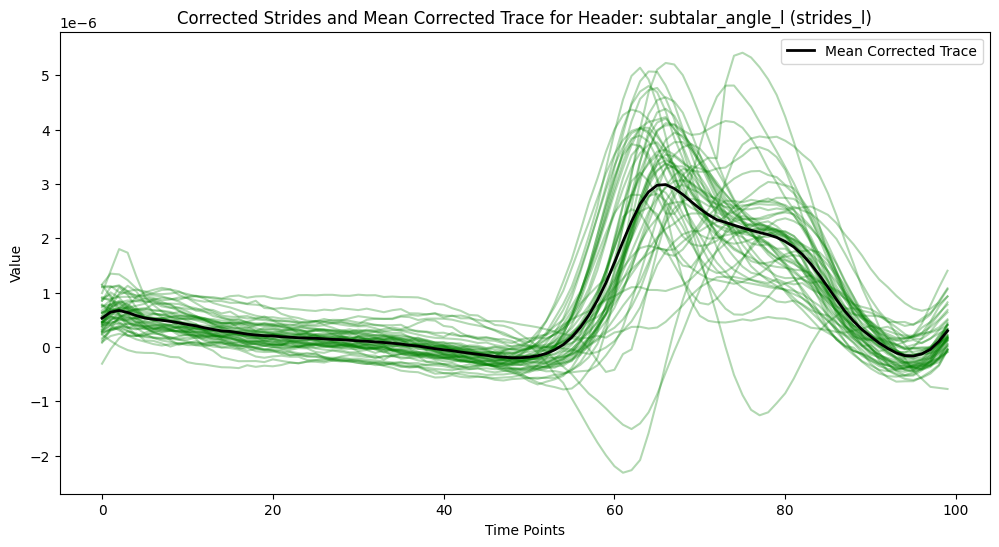

Processing header: mtp_angle_l
Strides type: <class 'dict'>, Strides keys: dict_keys(['strides_r', 'strides_l', 'header_type'])
Number of strides_r: 0
Number of strides_l: 50
Processing strides_r: Number of strides: 0
No strides available for strides_r in header mtp_angle_l, skipping.
Processing strides_l: Number of strides: 50
First stride type: <class 'dict'>
First stride normalized data shape/length: 100
First stride normalized data contents: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Stride min: 0.0, max: 0.0, mean: 0.0


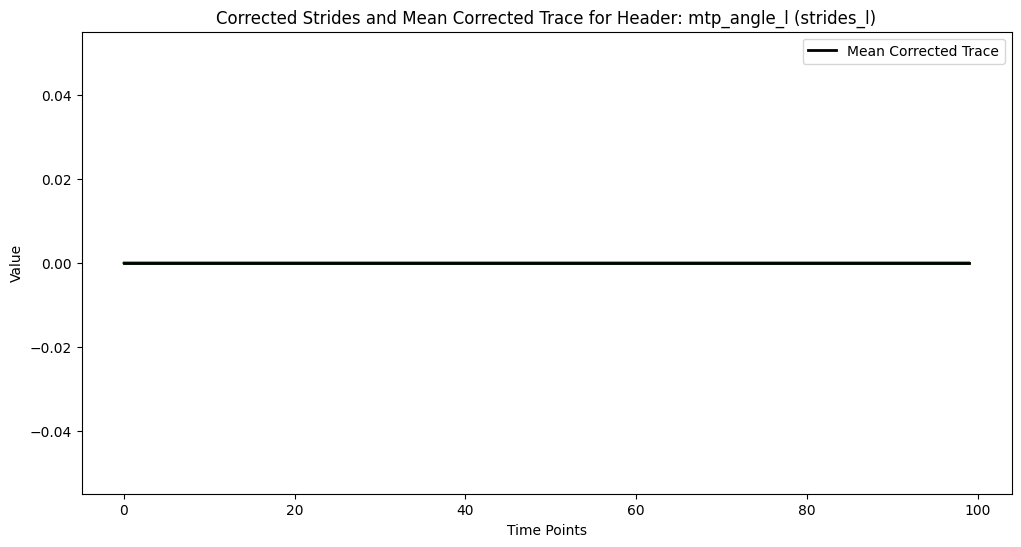

In [68]:

# Main Processing Pipeline
# Notebook Call for Testing
participant_numbers = [1]  # Testing with the first participant only
normative_directory = normative_traces_folder
output_directory = save_folder

process_participant(participant_numbers[0], normative_directory, output_directory)

